# Modeling a single-compartment Hodgkin-Huxley neuron using Brian2


In this notebook we make the first steps with `Python`, `Brian` simulator, and Hodgkin-Huxley equations.

We will use `brian2` for simulations because it works well with Jupyter notebooks and allows to easily set point models of neuronal groups and synaptic connections between them. We will exploit that property.

This thing you're using is called a "Jupyter notebook". It allows to combine explanatory notes, code, simulations and output all in one file.

First thing, we import some important modules (libraries) for plotting and simulations. We will use some constants too.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from brian2 import *

In [3]:
from brian2.units.constants import zero_celsius, gas_constant as R, faraday_constant as F

In [4]:
R/F

8.61733027e-05 * metre ** 2 * kilogram * second ** -3 * amp ** -1 * kelvin ** -1

In [5]:
import input_factory as inpf

## The original HH model

In [6]:
T = 6*kelvin + zero_celsius

In [7]:
def Nernst(Ci,Co,z=1):
    return R*T*log(Co/Ci)/F/z

We will use piece of axon 2cm long and 0.5mm in diameter

### Geometry parameters

In [23]:
radius = 0.25*mm
length = 2*cm
area = 2*pi*radius*length

print ('Axon area: {}'.format(area))

Axon area: 31.41592654 mm^2


So, this is how we define the equations. Read them carefully.

### Ion concentrations and reversal potentials

In [ ]:
Nai,Nao = 20*mM,155*mM
Ki,Ko = 75*mM,3*mM

Ena = Nernst(Nai,Nao)
Ek = Nernst(Ki,Ko)
El = -54.5*mV


In [14]:
print("Sodium reversal potential Ena = {}".format(Ena))
print("Potassium reversal potential EK = {}".format(Ek))

Sodium reversal potential Ena = 49.25781949 mV
Potassium reversal potential EK = -77.43095107 mV


### Electrical parameters

In [24]:
C = 1*uF/cm2*area
gna = 120*mS/cm2*area
gk = 36*mS/cm2*area
gl = 0.3*mS/cm2*area

In [12]:
print("Membrane capacitance: {}".format(C))
print("Max Na conductance: {}".format(gna))

Membrane capacitance: 314.15926536 nF
Max Na conductance: 37.69911184 mS


<font color=red size='big'>Exercise: print maximum potassium conductance below</font>

In [13]:
...

Ellipsis

### Potassium and leak currents

In [ ]:
# leak current
ileak_eqs = Equations("ileak = gl*(V-El) : amp")

# potassium current
ik_eqs = Equations("""
ik = gk*n**4*(V - Ek) : amp

# -- gating -- 
dn/dt = nalpha*(1-n) - nbeta*n : 1
nalpha = 0.01*(V + 55*mV)/(1 - exp(-(V + 55*mV)/10.0/mV))/mV/ms : 1/second
nbeta = 0.125*exp(-(V + 65*mV)/80/mV)/ms: Hz
""")

### Sodium current

In [ ]:
# sodium current
ina_eqs = Equations("""
ina = gna*m**3*h*(V-Ena) : amp 

# -- gating -- 
dm/dt = malpha*(1-m) - mbeta*m : 1
dh/dt = halpha*(1-h) - hbeta*h : 1

# -- activation gate rates -- 
malpha = 0.1*(V+40*mV)/(1 - exp(-(V+40*mV)/10./mV))/mV/ms : 1/second
mbeta = 4*exp(-(V+65*mV)/18/mV)/ms : 1/second

# -- inactivation -- 
halpha = 0.07*exp(-(V+65*mV)/20/mV)/ms : 1/second
hbeta = 1/(1 + exp(-(V+35*mV)/10/mV))/ms : 1/second
""")

### Combined equations

In [9]:
# Full set of equations
hh_eqs = Equations("""
dV/dt = (I_stim - ileak - ina - ik)/C : volt
stim_amp : 1
I_stim =  stim_amp*input_current(t,i): amp
""") + ik_eqs + ina_eqs + ileak_eqs

### Stimulating current

We will use a step input current to stimulate our neuron:

In [10]:
input_current = inpf.get_step_current(300, 800, 1*ms, 1.0*uA)

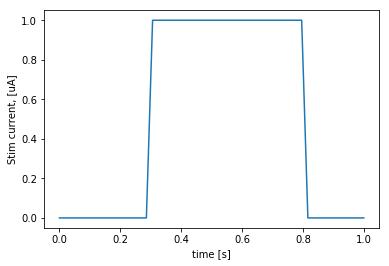

In [11]:
t_ = linspace(0,1)*second
plot(t_, input_current(t_,0)/uA)
xlabel('time [s]'); ylabel('Stim current, [uA]')

<font color='blue'>Always remember to label axes and use units</font>

Now we are starting our simulation. To be able to run several simulations in one noteboo, each should start with 
`start_scope()` statement.

In [ ]:
defaultclock.dt = 0.05*ms

In [15]:
start_scope()

G = NeuronGroup(1, hh_eqs, method='exponential_euler')
G.set_states(dict(V=-65.2*mV, m=0.05,h=0.6,n=0.3))

In [16]:
G.stim_amp = 0 
run(20*ms)
#states = G.get_states()
stateM = StateMonitor(G, variables=True,record=True)
store() # Store the initialized state of the model
#store()

### Excitability properties

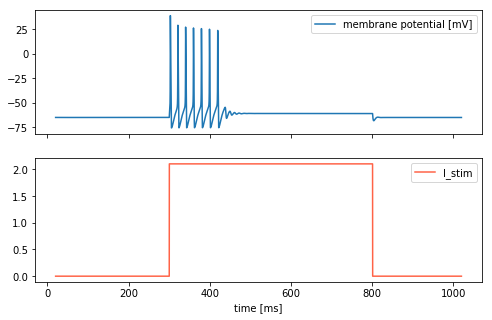

In [17]:
restore() # restore the initialized state and run new experiment
G.stim_amp = 2.1
run(1*second)
f,axs = subplots(2,1,sharex=True,figsize=(8,5))
axs[0].plot(stateM.t/ms, stateM.V[0]/mV,label='membrane potential [mV]')
axs[1].plot(stateM.t/ms, stateM.I_stim[0]/uA,c='tomato',label='I_stim')
axs[0].legend(); axs[1].legend()
xlabel('time [ms]'); 

Note the subthreshold oscillations. 


<font color='red'>**Exercise:**
 - Find minimal stimulus amplitude that leads to production of just one spike
 - Find minimal stimulus amplitude that leads to sustaned (tonic) spiking
 - Plot dynamics of $m$,$h$, and $n$ variables vs time during the stimulation
 - Which type of bifurcation from resting state do you think this neuron displays?

### Rebound spike

Rebound spike is a spike that is elicited by release of hyperpolarization

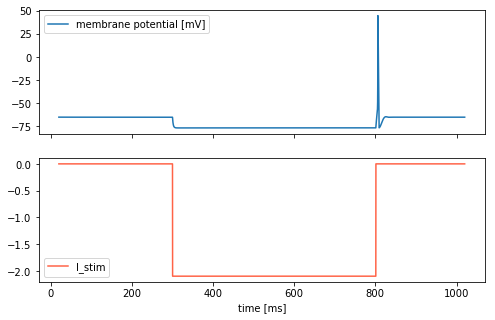

In [18]:
restore() # restore the initialized state and run new experiment
G.stim_amp = -2.1
run(1*second)
f,axs = subplots(2,1,sharex=True,figsize=(8,5))
axs[0].plot(stateM.t/ms, stateM.V[0]/mV,label='membrane potential [mV]')
axs[1].plot(stateM.t/ms, stateM.I_stim[0]/uA,c='tomato',label='I_stim')
axs[0].legend(); axs[1].legend()
xlabel('time [ms]'); 

<font color='red'>**Exercise:**
 - Find smallest stimulus amplitude (in absolute values) that leads to production of rebound spike

## Plotting gating parameters

Here we will use a group of dummy "neurons" each with different resting voltage to obtain $\alpha$ and $\beta$ dependencies on voltage.

In [19]:
start_scope()

Ndummy = 200
Vv = linspace(-90,40,Ndummy)*mV

dummy_eqs = """dV/dt = (V0-V)/ms: volt
               V0:volt
            """

dummyG = NeuronGroup(Ndummy,
                     Equations(dummy_eqs)+ik_eqs+ina_eqs,method='euler')
dummyG.V0 = Vv
dummyG.V = Vv
M = StateMonitor(dummyG,variables=True,record=True)
run(defaultclock.dt)

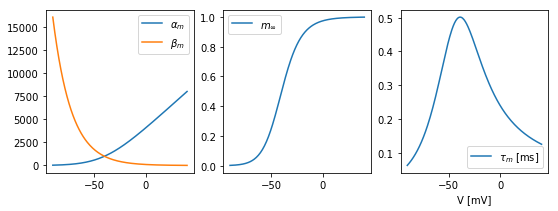

In [20]:
f,axs = subplots(1,3,sharex=True,figsize=(9,3))
axs[0].plot(Vv/mV, M.malpha,label=r'$\alpha_m$')
axs[0].plot(Vv/mV, M.mbeta,label=r'$\beta_m$')
axs[0].legend()

axs[1].plot(Vv/mV, M.malpha/(M.malpha+M.mbeta),label=r'$m_\infty$')
axs[1].legend()

axs[2].plot(Vv/mV, 1/(M.malpha+M.mbeta)/ms,label=r'$\tau_m$ [ms]')
axs[2].legend()


xlabel('V [mV]')


<font color='red'>**Exercise:**
 - Make graphs like the one above, but for $n$ and $h$ gating variables

  ## Neurons of the VCN (Rothman & Manis *J Neurophysiol* 2003)

In [25]:
import pandas as pd

In [26]:
soma_diameter = 21*um
soma_area = pi*soma_diameter**2
C = 0.9*uF/cm2*soma_area
C

12.46898124 * pfarad

In [27]:
Ek = -70*mV
Ena = +55*mV
Eh = -43*mV
Elk = -65*mV

### Sodium current

In [29]:
# sodium current
ina_eqs_vcn = Equations("""
ina_vcn = gnabar*m**3*h*(V-Ena) : amp
# -- gating -- 
dm/dt = (minf-m)/mtau : 1
dh/dt = (hinf-h)/htau : 1
minf= 1/(1 + exp(-(V+38*mV)/7/mV)) : 1
hinf = 1/(1 + exp((V+65*mV)/6/mV)) : 1
mtau = 10*ms/(5*exp((V+60*mV)/18/mV) + 36*exp(-(V+60*mV)/25/mV)) + 0.04*ms : second
htau = 100*ms/(7*exp((V+60*mV)/11/mV) + 10*exp(-(V+60*mV)/25/mV)) + 0.6*ms : second
""")

### Kht (high-threshold К current)




In [31]:
ikht_eqs = Equations("""
ikht = gkhtbar*(phi*n**2 + (1-phi)*p)*(V-Ek) : amp
phi =  0.85 : 1

dn/dt = (ninf - n)/ntau: 1
dp/dt = (pinf-p)/ptau : 1

ninf = 1/(1 + exp(-(V/mV+15)/5))**0.5 : 1
pinf = 1/(1 + exp(-(V/mV+23)/6)) : 1
ntau = (100/(11*exp((V/mV+60.0)/24.0) + 21.0*exp(-(V/mV+60.0)/23.0)) + 0.7)*ms : second
ptau = (100/(4*exp((V/mV+60.0)/32.0) + 5.0*exp(-(V/mV+60.0)/22.0)) + 5.0)*ms   : second
""")

### Klt (low-threshold К current)


In [32]:
iklt_eqs = Equations("""
iklt = gkltbar*(w**4)*z*(V-Ek) : amp

dw/dt = (winf-w)/wtau : 1
dz/dt = (zinf-z)/ztau : 1

winf = (1 + exp(-(V/mV+48)/6.0))**-0.25 : 1
wtau = (100/(6.0*exp((V/mV+60.0)/6.0) + 16.0*exp(-(V/mV+60.0)/45.0)) + 1.5)*ms: second

zinf = (1-0.5)*(1 + exp((V/mV+71)/10.0))**-1 + 0.5 : 1
ztau = (1000/(exp((V/mV+60)/20.0) + exp(-(V/mV+60)/8.0)) + 50)*ms : second
""")

### Ih (hyperpolarization-activated current)

In [33]:
ih_eqs = Equations("""
ih = ghbar*r*(V-Eh) : amp
dr/dt = (rinf-r)/rtau : 1
rinf = 1/(1 + exp((V/mV+76)/7)) : 1
rtau = (10**5/(237*exp((V/mV+60)/12) + 17*exp(-(V/mV+60)/14)) + 25)*ms : second
""")


### Full vcn equations:

In [34]:
vcn_equations = Equations("""
dV/dt = (I_stim - ileak - ina_vcn - ikht - iklt - ih)/C : volt
ileak = glk*(V-Elk) : amp
stim_amp : 1
I_stim =  stim_amp*input_current(t,i): amp
""") + ina_eqs_vcn + ikht_eqs + iklt_eqs + ih_eqs

### Conductances in nS

In [35]:
rm_params = pd.read_csv("Rothman-Manis-2003-table1.csv", index_col=0)
rm_params

,Ic,It,I_II,II_I,II
gnabar,1000.0,1000.0,1000,1000.0,1000
gkhtbar,150.0,80.0,150,150.0,150
gkltbar,0.0,0.0,20,35.0,200
gkabar,0.0,65.0,0,0.0,0
ghbar,0.5,0.5,2,3.5,20
glk,2.0,2.0,2,2.0,2


In [36]:
def convert_rm_table_units(key):
    return {k:v*nS for k,v in dict(rm_params[key]).items()}

## Setting up the neurons

### Type I  (stellate) neurons

In [37]:
start_scope()

G_typeIc =  NeuronGroup(1, vcn_equations, namespace=convert_rm_table_units('Ic'), method='exponential_euler')

In [38]:
input_current = inpf.get_step_current(300, 450, 1*ms, 1.0*pA)

In [39]:
run(200*ms)
MIc = StateMonitor(G_typeIc, variables=True, record=True)
store()

In [40]:
restore()
G_typeIc.stim_amp = 50
run(0.5*second)
vplus = MIc.V[0][:]
#plot(MIc.t/ms, MIc.V[0]/mV)

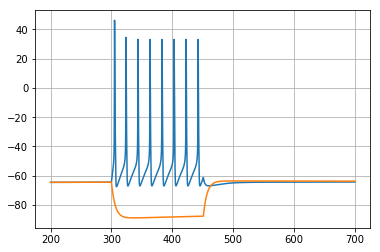

In [41]:
restore()
G_typeIc.stim_amp = -50
run(0.5*second)
plot(MIc.t/ms, vplus/mV)
plot(MIc.t/ms, MIc.V[0]/mV)
grid()

### Type II (Bushy) neurons

In [42]:
start_scope()
G_typeII =  NeuronGroup(1, vcn_equations, namespace=convert_rm_table_units('II'), method='exponential_euler')

In [43]:
run(200*ms)
MII = StateMonitor(G_typeII, variables=True, record=True)
store()

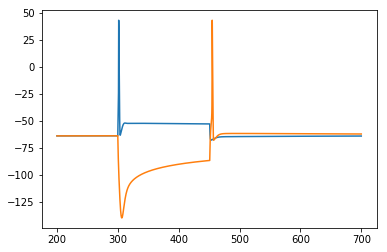

In [46]:
restore()
G_typeII.stim_amp = 400
run(0.5*second)
plot(MII.t/ms, MII.V[0]/mV, label='+300pA')

restore()
G_typeII.stim_amp = -400
run(0.5*second)
plot(MII.t/ms, MII.V[0]/mV,label='-300pA')
xlabel('time [ms]')
ylabel('membrane voltage [mV]')

<font color=red>
**Exersice:**
   - Explain, why the membrane voltage sags during hyperpolarizing stimulus
   - why does it sag more in the typeII model?
   - test if typeI neuron can encode input current amplitude in spiking frequency
   - which current is the slowest?

<font color='red'>
**Themes for projects (may want to choose one)**
   - Investigate bifurcations of the resting state of the typeI and typeII neurons
   - Investigate response of typeI and typeII models to stimulation with noisy injected current or injected conductance. You may want to read Brian2 documentation on how to do this kind of simulation